# Setup

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

from scipy.stats import uniform
from tqdm.notebook import tqdm

In [102]:
df = pd.read_csv('https://github.com/Adkurrr/Sentiment-Analysis-with-Aspect-Based-Approach-on-Spotify-App-with-SVM/blob/main/Dataset/reviews.csv?raw=true', delimiter=',')
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [105]:
#ubah tipe data date
df['Time_submitted'] = pd.to_datetime(df['Time_submitted'])

# Karena jumlah dataset yang sangat banyak(61.594 baris data), maka untuk analisis ini hanya diambil bulan maret saja (7780 baris data)
df = df[(df['Time_submitted'] >= '2022-03-01') & (df['Time_submitted'] <= '2022-03-31')]

# Praproses Data

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7780 entries, 41125 to 48904
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Time_submitted  7780 non-null   datetime64[ns]
 1   Review          7780 non-null   object        
 2   Rating          7780 non-null   int64         
 3   Total_thumbsup  7780 non-null   int64         
 4   Reply           37 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 364.7+ KB


### Handling missing value

In [107]:
df.isnull().sum()

Time_submitted       0
Review               0
Rating               0
Total_thumbsup       0
Reply             7743
dtype: int64

In [108]:
df.drop('Reply', axis=1, inplace=True)

### Handing duplicated data

In [109]:
df.duplicated().sum()

0

In [110]:
df = df.dropna(subset=['Review', 'Rating'])

### Lowercase, clear stop words and clear punctuations

In [ ]:
# nltk.download('stopwords')

In [112]:
#download stopwords terlebih dahulu jika terjadi error
def clean(review):
    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

df['Review'] = df['Review'].apply(clean)
df.head(5)

,Time_submitted,Review,Rating,Total_thumbsup
41125,2022-03-30 23:53:37,locked account worst part requires login conta...,2,1
41126,2022-03-30 23:51:44,constantly crashes deletes downloaded podcast ...,1,2
41127,2022-03-30 23:47:11,easy use find convenient want listen particula...,5,1
41128,2022-03-30 23:44:13,many fake profiles trying fix things total mes...,1,3
41129,2022-03-30 23:33:59,hate app much want listen songs pick,1,1


In [113]:
df.drop('Time_submitted', axis=1, inplace=True)
df.drop('Total_thumbsup', axis=1, inplace=True)

# Exploratory Data Analysis

### Visualisasi jumlah rating positif, negatif dan netral

In [114]:
df['Rating'].value_counts()

Rating
5    2556
1    2433
4    1030
2     912
3     849
Name: count, dtype: int64

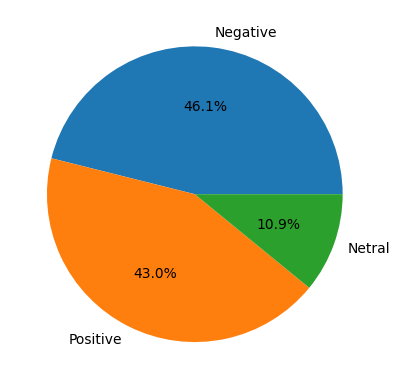

In [115]:
def ratings(rating):
    if rating>3 and rating<=5:
        return "Positive"
    elif rating>0 and rating<3:
        return "Negative"
    else:
        return "Netral"

df['Rating'] = df['Rating'].apply(ratings)
plt.pie(df['Rating'].value_counts(), labels=df['Rating'].unique().tolist(), autopct='%1.1f%%')
plt.show()

### mencari kata paling sering muncul

In [120]:
def corpus(text):
    text_list = text.split()
    return text_list

df['Review_lists'] = df['Review'].apply(corpus)
corpus = []
for index, row in df.iterrows():
    corpus += row['Review_lists']
len(corpus)

mostCommon = Counter(corpus).most_common(10)
mostCommon

[('app', 4525),
 ('music', 3191),
 ('spotify', 2641),
 ('songs', 2489),
 ('song', 1690),
 ('premium', 1398),
 ('cant', 1381),
 ('like', 1318),
 ('listen', 1312),
 ('play', 1302)]

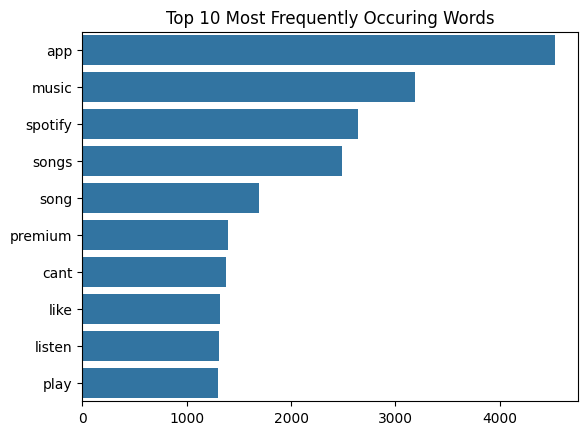

In [121]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

### WordCloud

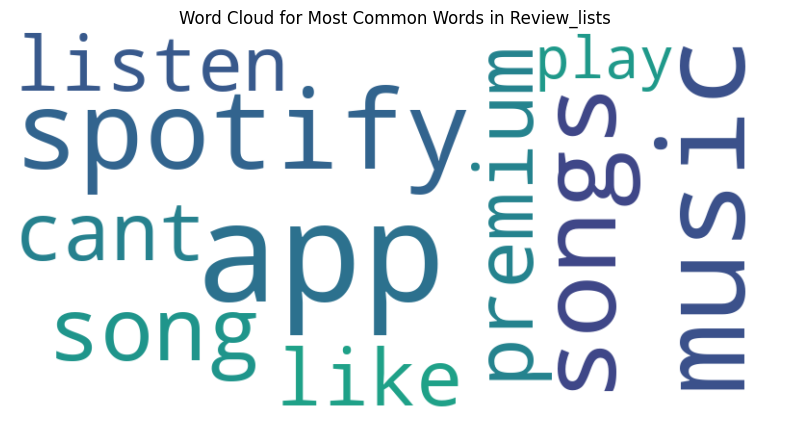

In [122]:
from wordcloud import WordCloud

word_freq_dict = dict(mostCommon)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Review_lists')
plt.axis('off')
plt.show()

# Model

### Sentimen analisis dengan NLTK

In [ ]:
#nltk.download('vader_lexicon')

In [126]:
#download dahulu vander_lexicon jika terjadi error
sia = SentimentIntensityAnalyzer()
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    reviews = row['Review']
    num = i
    res[num] = sia.polarity_scores(reviews)

  0%|          | 0/7780 [00:00<?, ?it/s]

In [127]:
# Membuat DataFrame baru dari hasil analisis sentimen
sentiment_df = pd.DataFrame(res).T

# Membuat fungsi untuk mengklasifikasikan sentimen
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Mengubah skor sentimen menjadi kategori
sentiment_df['sentiment_category'] = sentiment_df['compound'].apply(classify_sentiment)

# Gabungkan DataFrame sentimen dengan DataFrame awal berdasarkan indeks
df = df.join(sentiment_df[['sentiment_category']])
df.drop('Rating', axis=1, inplace=True)

In [128]:
df.head(5)

,Review,Review_lists,sentiment_category
41125,locked account worst part requires login conta...,"[locked, account, worst, part, requires, login...",negative
41126,constantly crashes deletes downloaded podcast ...,"[constantly, crashes, deletes, downloaded, pod...",neutral
41127,easy use find convenient want listen particula...,"[easy, use, find, convenient, want, listen, pa...",positive
41128,many fake profiles trying fix things total mes...,"[many, fake, profiles, trying, fix, things, to...",neutral
41129,hate app much want listen songs pick,"[hate, app, much, want, listen, songs, pick]",negative


### One hot encoding

In [129]:
# Membuat mapping untuk encoding
sentimen_mapping = {"negative": -1, "neutral": 0, "positive": 1}

# Melakukan encoding pada kolom "sentimen"
df["sentimen_encoded"] = df["sentiment_category"].map(sentimen_mapping)

In [130]:
df.head(5)

,Review,Review_lists,sentiment_category,sentimen_encoded
41125,locked account worst part requires login conta...,"[locked, account, worst, part, requires, login...",negative,-1
41126,constantly crashes deletes downloaded podcast ...,"[constantly, crashes, deletes, downloaded, pod...",neutral,0
41127,easy use find convenient want listen particula...,"[easy, use, find, convenient, want, listen, pa...",positive,1
41128,many fake profiles trying fix things total mes...,"[many, fake, profiles, trying, fix, things, to...",neutral,0
41129,hate app much want listen songs pick,"[hate, app, much, want, listen, songs, pick]",negative,-1


In [131]:
#hapus baris data yang kosong
df = df.dropna(subset=['Review', 'Review_lists','sentiment_category','sentimen_encoded'])

### train test split

In [132]:
train, test = train_test_split(df, test_size=0.2, random_state=1)
X_train = train['Review'].values
X_test = test['Review'].values
y_train = train['sentimen_encoded']
y_test = test['sentimen_encoded']

In [133]:
stemmer = PorterStemmer()
def stem(doc):
    return ' '.join([stemmer.stem(w) for w in doc])

en_stopwords = list(stopwords.words("english"))
vectorizer = CountVectorizer(
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

df['Review_lists_stemmed'] = df['Review_lists'].apply(stem)
review_list_vectorized = vectorizer.fit_transform(df['Review_lists_stemmed'])

In [134]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [135]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer,
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]},
                    cv = kfolds,
                    scoring="f1_macro",
                    verbose=1,
                    n_jobs=-1)

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.6442887669173024

In [136]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)
    pred = model.predict(X)

    auc = roc_auc_score(y, pred_proba, multi_class='ovr')
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred, average='macro')
    prec = precision_score(y, pred, average='macro')
    rec = recall_score(y, pred, average='macro')
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

report_results(grid_svm.best_estimator_, X_test, y_test)

{'auc': 0.887212643577706,
 'f1': 0.6442887669173024,
 'acc': 0.7422879177377892,
 'precision': 0.6268465670342116,
 'recall': 0.7047401744926778}

###test model

In [152]:
def test_model(comment):
  predict = grid_svm.predict([comment])
  if predict == [1]:
    print("Positive review")
  else:
    print("Negative review")

In [156]:
review_1 = "constantly crashes deletes downloaded podcast requiring constantly burn data redownloading things ive already downloaded"
test_model(review_1)

Negative review


In [155]:
review_2 = "easy use find convenient want listen particular artist like theres always playlist spotify artist"
test_model(review_2)

Positive review
